# Br41n.io hackaton

Data visualization

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import mne

from scipy.io import loadmat
from mne.io import RawArray
from mne import create_info

## initialisation of the variables

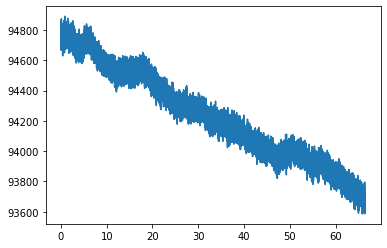

In [3]:
s01 = loadmat('dataset/s01.mat')
eeg_s01 = s01['eeg']
value = eeg_s01[0,0]

srate = value['srate'][0,0]
n_trials = value['n_imagery_trials'][0,0]

bad_trials = value['bad_trial_indices']
event_onset = value['imagery_event'][0]
senloc = value['senloc']

rest_signal = value['rest']
imagery_left = value['imagery_left']

npnts = len(rest_signal[0])
timevec = np.arange(0, npnts)/srate

plt.plot(timevec, rest_signal[29])

## mne object creation

Creating RawArray with float64 data, n_channels=64, n_times=34048
    Range : 0 ... 34047 =      0.000 ...    66.498 secs
Ready.
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 3379 samples (6.600 sec)



<ipython-input-105-1555cf62921f>:5: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_array.set_montage(mne.channels.make_dig_montage(montage))


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Filter length: 3379 samples (6.600 sec)



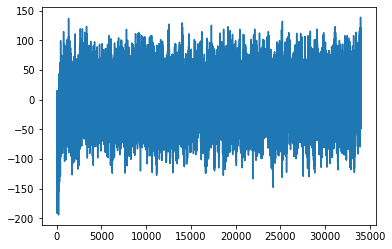

In [105]:
ch_names = mne.channels.make_standard_montage('biosemi64').ch_names
raw_array = RawArray(rest_signal[:64], info=create_info(sfreq=srate, ch_types='eeg', ch_names=ch_names))

montage = {key:value for key, value in zip(ch_names, senloc)}
raw_array.set_montage(mne.channels.make_dig_montage(montage))

raw_array.notch_filter(60)
raw_array.filter(0.5, None)
plt.plot(timevec, raw_array.get_data('POz')[0])

## Adding annotations